# Methods and Results

Since we are predicting a categorical variable, we will use KNN Classification to conduct our analysis and compare it to a baseline model using a DummyClassifier. We'll start by importing the necessary packages, reading in the data, splitting the data into train and test splits, and then separating the feature columns from the target column.

In [33]:
# importing required libraries for analysis
import altair as alt
import pandas as pd
import numpy as np
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (FunctionTransformer, Normalizer, OneHotEncoder, StandardScaler, normalize, scale)
from sklearn.compose import make_column_transformer
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, classification_report

# setting random state to have reproducible results
random_state=12

# read in data
patient_data = pd.read_csv("data/ehr_data.csv")

# splitting data into train and test splits
patient_train, patient_test = train_test_split(patient_data, test_size=0.2, random_state=12, stratify=patient_data["SOURCE"])

# separate feature vectors from target
X_train = patient_train.drop(columns = ["SOURCE"])
y_train = patient_train["SOURCE"]
X_test = patient_test.drop(columns = ["SOURCE"])
y_test = patient_test["SOURCE"]

## Preprocessing the Data
Since KNN algorithm uses Euclidian distance to determine how similar data points are to each cluster center, we will scale in each numeric feature in our pre-processing so they have same effect on deciding cluster assignment.  
To allow the binary feature to be used as a predictor, we converted the binary feature (sex) by assigning the values to be 0 or 1 instead of M or F.  
No imputation is needed since there are no missing values in the dataset.


In [34]:
# preprocess features
numeric_feats = X_train.select_dtypes('number').columns.to_list()
numeric_transformer = make_pipeline(StandardScaler())

categorical_binary_feats = ["SEX"]
categorical_binary_transformer = make_pipeline(OneHotEncoder(drop="if_binary", dtype=int))

preprocessor = make_column_transformer((numeric_transformer, numeric_feats),
                                       (categorical_binary_transformer, categorical_binary_feats)
                                       )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Baseline Model
To create a baseline model to compare the final knn model to, I made a DummyClassifier that will predict the treatment randomly at a frequency respective to the treatment distribution of the training data.

In [35]:
# creating DummyClassifier as a baseline model to compare estimators to
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, pos_label='in'),
           'recall': make_scorer(recall_score, pos_label='in'),
           'f1': make_scorer(f1_score, pos_label='in') }

dummy_classifier = DummyClassifier(strategy = "stratified", random_state = 12)

dummy_scores = pd.DataFrame(
    cross_validate(
        dummy_classifier, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring
    )
)

dummy_mean = dummy_scores.mean()
dummy_mean

fit_time           0.001069
score_time         0.020399
test_accuracy      0.516296
train_accuracy     0.513318
test_precision     0.406146
train_precision    0.396941
test_recall        0.424699
train_recall       0.392079
test_f1            0.415214
train_f1           0.394495
dtype: float64

As shown above, the DummyClassifier has a validation score of 52%

## KNN Classifier

### Parameter Tuning
To find the optimal value of k that maximizes the accuracy of the model, 5-fold cross-validation was used for values of k from 1 to 20.

In [36]:
# find the k value that yields the best accuracy estimate
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": []}

for n in range(1,21):
    knn_model = KNeighborsClassifier(n_neighbors=n)
    cv_scores = cross_validate(knn_model, X_train, y_train, cv=5, return_train_score=True)
    results_dict["n_neighbors"].append(n)
    results_dict["mean_train_score"].append(cv_scores["train_score"].mean())
    results_dict["mean_cv_score"].append(cv_scores["test_score"].mean())

results_df = pd.DataFrame(results_dict)

results_df.sort_values(by=["mean_cv_score"], ascending=False).head(1)

,n_neighbors,mean_train_score,mean_cv_score
18,19,0.764169,0.740157


In [37]:
best_k = int(results_df.loc[results_df['mean_cv_score'].idxmax()]['n_neighbors'])
best_k

19

As shown above, 19 is the best k value from 1 to 20 and yields a validation score of 74% which is much higher compared to the validation score of the DummyClassifier (52%).

### Training and Testing

In [38]:
# make new model with best k
best_model = KNeighborsClassifier(n_neighbors=best_k)

# retrain classifier
best_model.fit(X_train, y_train)

# get predictions on test data
best_model.predict(X_test)

# get estimate of accuracy of classifier on test data
test_score = best_model.score(X_test, y_test)
test_score

0.7304643261608154

The accuracy score of the knn classifier with k=19 on the test set is 73%.

### Model Evaluation

To gain more insight into the KNN model's performance, the following confusion matrix shows its predictions compared to the truth.

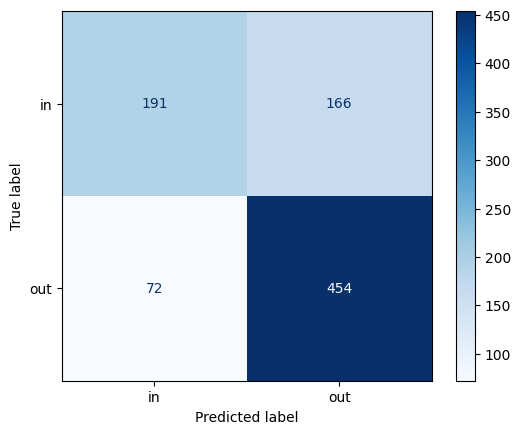

In [39]:
predictions = best_model.predict(X_test)

# make a confusion matrix with the predictions
cm = confusion_matrix(y_test, predictions, labels = best_model.classes_)

# visualize the confusion matrix
cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=best_model.classes_).plot(cmap='Blues')
cm_plot

*Figure 3: Confusion matrix of the KNN model's predictions*

This confusion matrix shows that in the testing dataset:
- 191 patients were correctly predicted to need in-patient care
- 454 patients were correctly predicted to need out-patient care
- 72 patients were incorrectly predicted to need in-patient care (they needed out-patient care)
- 166 patients were incorrectly predicted to need out-patient care (they needed in-patient care)

To gain even more understanding of the model's performance, the classification report below shows the precision, recall, and f1 scores

In [40]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          in       0.73      0.54      0.62       357
         out       0.73      0.86      0.79       526

    accuracy                           0.73       883
   macro avg       0.73      0.70      0.70       883
weighted avg       0.73      0.73      0.72       883



- The weighted average of the precision score was 0.73, meaning that when the classifier predicted that a patient needed in-patient care, it was correct 73% of the time.
- The weighted average of the recall score was 0.73, meaning that among the patients that needed in-patient care, it identified 73% of them.
- The weighted average of the f1 score was 0.72, which is the harmonic mean of precision and recall.

### Exploring the Model

Let's explore the model with more visualizations.

In [41]:
# make the predictions into a dataframe and rename the prediction column to "prediction"
prediction_df = pd.DataFrame(predictions)
prediction_df = prediction_df.rename(columns={prediction_df.columns[0]:'prediction'})

# reset index of testing dataframe
patient_test = patient_test.reset_index()

# concatenate the prediction dataframe to the testing dataframe
patient_test_predict = pd.concat([patient_test, prediction_df], axis=1)

In [65]:
sex_vs_prediction = alt.Chart(patient_test_predict, width = 400, height = 300
                               ).mark_bar().encode(
                                   x = alt.X("prediction", title = "Predicted Treatment Type", axis=alt.Axis(labelAngle=0)),
                                   xOffset="SEX",
                                   y = alt.Y("count()", title = "Number of Patients"),
                                   color = alt.Color("SEX", title = "Sex", scale = alt.Scale(scheme='dark2')), 
                                   tooltip = alt.Tooltip("count()")
                               )
sex_vs_prediction

alt.Chart(...)

In [86]:
sex_distribution = alt.Chart(patient_test_predict, width = 400, height = 100
                               ).mark_bar().encode(
                                   x = alt.X("count()", title = "Number of Patients"),
                                   y = alt.Y("SEX", title = "Sex"),
                                   color = alt.Color("SEX", legend = None, scale = alt.Scale(scheme='set2')),
                                   tooltip = alt.Tooltip("count()")
                               )
sex_distribution

alt.Chart(...)

In [42]:
#numeric_plot = alt.Chart(data, width = w, height = h).mark_bar().encode(
#    x = alt.X(column, title = x_title, bin = alt.Bin(maxbins=30)),
#    y = alt.Y("count()", title = "Number of Patients")
#    )


# list of titles for each histogram
histogram_titles = ["Haematocrit level (% of blood volume)", "Haemoglobin level (g/dl)", "Erythrocyte level (million/ml)",
                    "Leucocyte level (thousand/mcl)", "Thrombocyte level (thousand/mcl)", "MCH level (pg/cell)",
                    "MCHC level (g/dl)", "MCV level (fl)", "Age (years)"]

# 'HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX', 'SOURCE', 'prediction'


In [116]:
select_sex = alt.selection_multi(fields=["SEX"])

sex_distribution = alt.Chart(patient_test_predict, width = 400, height = 100
                               ).mark_bar().encode(
                                   x = alt.X("count()", title = "Number of Patients"),
                                   y = alt.Y("SEX", title = "Sex"),
                                   color = alt.condition(select_sex, "SEX", alt.value('lightgray')),
                                   tooltip = alt.Tooltip("count()")
                               ).add_selection(select_sex)
sex_distribution

c:\Users\Stephanie\miniconda3\envs\classification_env\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.Chart(...)

In [121]:

age_vs_haematocrit = alt.Chart(patient_test_predict, width = 400, height = 300
                               ).mark_circle(opacity=0.3).encode(
                                   x = alt.Y("HAEMATOCRIT", title = "Haematocrit level (% of blood volume)"),
                                   y = alt.X("AGE", title = "Age (years)"),
                                   color = alt.Color("prediction", title = "Predicted Treatment Type", scale = alt.Scale(scheme='dark2')),
                               )
(age_vs_haematocrit & sex_distribution).resolve_scale(color='independent')
#age_vs_haematocrit
# change colour of points if selected or not via bar char of sex!!! don't need to make legend clickable for prediction

alt.VConcatChart(...)

In [128]:
age_vs_haematocrit = alt.Chart(patient_test_predict, width = 400, height = 300
                               ).mark_circle(opacity=0.3).encode(
                                   x = alt.Y("HAEMATOCRIT", title = "Haematocrit level (% of blood volume)"),
                                   y = alt.X("AGE", title = "Age (years)"),
                                   color = alt.condition(select_sex, "prediction", alt.value('lightgray')),
                               )
(age_vs_haematocrit & sex_distribution).resolve_scale(color='independent')

alt.VConcatChart(...)

In [147]:
input_dropdown = alt.binding_select(options=["M", "F"], name="SEX")
sex_selection = alt.selection_single(fields=['SEX'],
                                     bind=input_dropdown)

age_vs_haematocrit = alt.Chart(patient_test_predict, width = 400, height = 300
                               ).mark_circle(opacity=0.3).encode(
                                   x = alt.Y("HAEMATOCRIT", title = "Haematocrit level (% of blood volume)"),
                                   y = alt.X("AGE", title = "Age (years)"),
                                   color = alt.condition(sex_selection, "prediction", alt.value('lightgray')),
                               ).add_selection(sex_selection)

age_vs_haematocrit

c:\Users\Stephanie\miniconda3\envs\classification_env\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\Stephanie\miniconda3\envs\classification_env\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.Chart(...)

In [146]:
input_dropdown = alt.binding_select(options=["All", "M", "F"], name="SEX")
sex_selection = alt.selection_single(fields=['SEX'],
                                     bind=input_dropdown)

age_vs_haematocrit = alt.Chart(patient_test_predict, width = 400, height = 300
                               ).mark_circle(opacity=0.3).encode(
                                   x = alt.Y("HAEMATOCRIT", title = "Haematocrit level (% of blood volume)"),
                                   y = alt.X("AGE", title = "Age (years)"),
                                   color = alt.condition(sex_selection, "prediction", alt.value('lightgray')),
                               ).add_selection(sex_selection).transform_filter(
                                   f"({sex_selection.SEX}[0] == 'All') || ({sex_selection.SEX}[0] == datum.SEX)"
                                   )

age_vs_haematocrit

c:\Users\Stephanie\miniconda3\envs\classification_env\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\Stephanie\miniconda3\envs\classification_env\Lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.Chart(...)

In [44]:
patient_test_predict.columns.to_list()

['index',
 'HAEMATOCRIT',
 'HAEMOGLOBINS',
 'ERYTHROCYTE',
 'LEUCOCYTE',
 'THROMBOCYTE',
 'MCH',
 'MCHC',
 'MCV',
 'AGE',
 'SEX',
 'SOURCE',
 'prediction']